🔵 Training normal model (5 epochs)...
Epoch 1/5 | Loss: 0.2706 | Accuracy: 96.13% | Frobenius Norm: 13.64
Epoch 2/5 | Loss: 0.1126 | Accuracy: 96.83% | Frobenius Norm: 16.27
Epoch 3/5 | Loss: 0.0795 | Accuracy: 97.17% | Frobenius Norm: 18.37
Epoch 4/5 | Loss: 0.0609 | Accuracy: 97.18% | Frobenius Norm: 20.23
Epoch 5/5 | Loss: 0.0487 | Accuracy: 97.59% | Frobenius Norm: 21.94
🔴 Training overfit model (50 epochs)...
Epoch 1/50 | Loss: 0.2760 | Accuracy: 95.47% | Frobenius Norm: 13.59
Epoch 2/50 | Loss: 0.1171 | Accuracy: 96.32% | Frobenius Norm: 16.17
Epoch 3/50 | Loss: 0.0825 | Accuracy: 96.97% | Frobenius Norm: 18.30
Epoch 4/50 | Loss: 0.0625 | Accuracy: 97.08% | Frobenius Norm: 20.11
Epoch 5/50 | Loss: 0.0517 | Accuracy: 97.64% | Frobenius Norm: 21.89
Epoch 6/50 | Loss: 0.0420 | Accuracy: 97.71% | Frobenius Norm: 23.44
Epoch 7/50 | Loss: 0.0336 | Accuracy: 97.48% | Frobenius Norm: 24.93
Epoch 8/50 | Loss: 0.0330 | Accuracy: 97.33% | Frobenius Norm: 26.38
Epoch 9/50 | Loss: 0.0236 | Ac

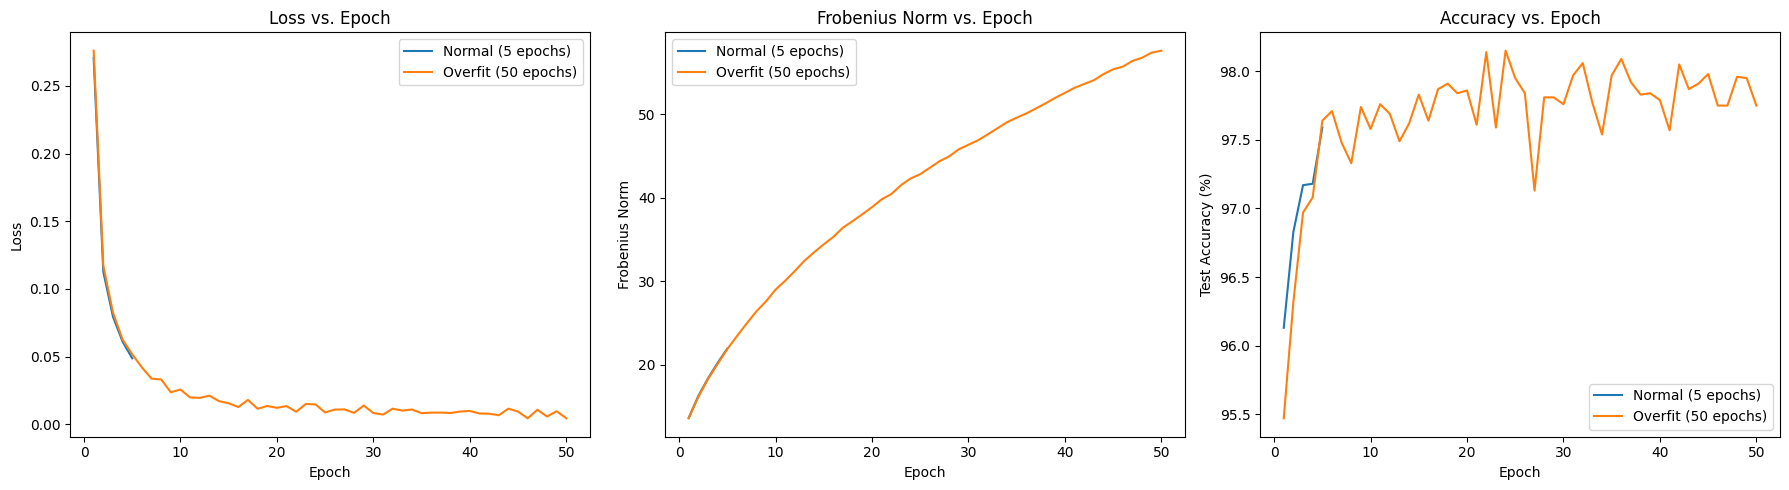

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

class ThreeLayerNN(nn.Module):
    def __init__(self, input_size=784, hidden1=128, hidden2=64, output_size=10):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

def compute_frobenius_norm(model):
    weights = [param for name, param in model.named_parameters() if 'weight' in name]
    all_weights = torch.cat([w.flatten() for w in weights])
    return torch.norm(all_weights, p=2).item()

def evaluate_accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

def train_model(model, loader, test_loader, epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses, norms, accs = [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)

        avg_loss = epoch_loss / len(loader.dataset)
        acc = evaluate_accuracy(model, test_loader)
        losses.append(avg_loss)
        norms.append(compute_frobenius_norm(model))
        accs.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc*100:.2f}% | Frobenius Norm: {norms[-1]:.2f}")
    
    return model, losses, norms, accs

print("🔵 Training normal model (5 epochs)...")
model_normal = ThreeLayerNN()
model_normal, normal_losses, normal_norms, normal_accs = train_model(model_normal, train_loader, test_loader, epochs=5)

print("🔴 Training overfit model (50 epochs)...")
model_overfit = ThreeLayerNN()
model_overfit, overfit_losses, overfit_norms, overfit_accs = train_model(model_overfit, train_loader, test_loader, epochs=50)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 6), normal_losses, label="Normal (5 epochs)")
plt.plot(range(1, 51), overfit_losses, label="Overfit (50 epochs)")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 6), normal_norms, label="Normal (5 epochs)")
plt.plot(range(1, 51), overfit_norms, label="Overfit (50 epochs)")
plt.title("Frobenius Norm vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Frobenius Norm")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, 6), [a * 100 for a in normal_accs], label="Normal (5 epochs)")
plt.plot(range(1, 51), [a * 100 for a in overfit_accs], label="Overfit (50 epochs)")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()
